In [1]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
import itertools
from keras.layers import LSTM

from keras.layers import Dropout

2025-06-03 14:44:48.066549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748961888.342756      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748961888.424023      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv(
    '/kaggle/input/tempura/Dataset_NH3_and_H2S_March_to_April.csv',
    sep=',',
    parse_dates=['Timestamp'],
    low_memory=False,
    na_values=['nan', '?'],
    index_col='Timestamp'
)

df =df.iloc[:,:2]

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [12]:
import os
import wandb


os.environ["WANDB_LOG_MODEL"] = "false"
os.environ["WANDB_API_KEY"] = "05e77228f87f2442c1158e950b18e36123dd4c6c"
wandb.init(project="lstm-forecasting-nh3-h2s", config={
    "epochs": 5,
    "batch_size": 32,
    "n_in":24,
    "n_out":1,
    "optimizer": "adam",
    "loss_function": "mean_squared_error",
    "lstm_units": 100,
    "dropout_rate": 0.3
})

epoch,▁▃▅▆█
loss,█▂▁▁▁
val_loss,▆█▁▇▂
best_epoch,2
best_val_loss,0.0
epoch,4
loss,0.00066
val_loss,1e-05


In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    for i in range(n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'var{j+1}(t)' for j in range(n_vars)]
        else:
            names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [13]:
from wandb.integration.keras import WandbCallback
class LSTMDataPreparer:
    def __init__(self, df: pd.DataFrame, n_in: int = 3, n_out: int = 1, test_days: int = 365):
        self.df = df.copy()
        self.n_in = n_in
        self.n_out = n_out
        self.test_days = test_days
        self.n_features = df.shape[1]
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.reframed = None
        self.model = None

        self.train_X = None
        self.train_y = None
        self.test_X = None
        self.test_y = None

    def preprocess(self):
        values = self.df.values.astype('float32')
        scaled = self.scaler.fit_transform(values)
        self.reframed = series_to_supervised(scaled, self.n_in, self.n_out)
        return self.reframed

    def create_train_test(self):
        if self.reframed is None:
            self.preprocess()

        values = self.reframed.values
        test_size = self.test_days * 24
        train = values[:-test_size, :]
        test = values[-test_size:, :]

        n_obs = self.n_in * self.n_features
        self.train_X, self.train_y = train[:, :n_obs], train[:, n_obs:]
        self.test_X, self.test_y = test[:, :n_obs], test[:, n_obs:]

        self.train_X = self.train_X.reshape((self.train_X.shape[0], self.n_in, self.n_features))
        self.test_X = self.test_X.reshape((self.test_X.shape[0], self.n_in, self.n_features))

        print("Shapes:")
        print("train_X:", self.train_X.shape)
        print("train_y:", self.train_y.shape)
        print("test_X:", self.test_X.shape)
        print("test_y:", self.test_y.shape)

    def inverse_transform_y(self, y_scaled):
        dummy = np.zeros((y_scaled.shape[0], self.n_features))
        dummy[:, :y_scaled.shape[1]] = y_scaled
        return self.scaler.inverse_transform(dummy)[:, :y_scaled.shape[1]]

    def train_model(self):
        if self.train_X is None or self.train_y is None:
            self.create_train_test()

        self.model = Sequential()
        self.model.add(LSTM(100, input_shape=(self.train_X.shape[1], self.train_X.shape[2])))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(self.train_y.shape[1]))
        self.model.compile(loss='mean_squared_error', optimizer='adam')

        history = self.model.fit(
            self.train_X, self.train_y,
            epochs=wandb.config.epochs,
            batch_size=wandb.config.batch_size,
            validation_data=(self.test_X, self.test_y),
            verbose=2,
            shuffle=False,
            callbacks=[WandbCallback(
                save_model=False,
                log_weights=True,
                log_evaluation=False,
                save_graph=False
            )]
        )

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()

    def evaluate(self):
        if self.model is None:
            raise ValueError("Model is not trained yet.")
        if self.test_X is None or self.test_y is None:
            self.create_train_test()

        y_pred = self.model.predict(self.test_X)
        y_pred_scaled = self.inverse_transform_y(y_pred)
        y_true_scaled = self.inverse_transform_y(self.test_y)
        for i in range(y_pred.shape[1]):
            rmse = np.sqrt(mean_squared_error(self.test_y[:, i], y_pred[:, i]))
            print(f"Test Scaled RMSE var{i+1}: {rmse:.3f}")
        for i in range(y_pred.shape[1]):
            rmse = np.sqrt(mean_squared_error(y_true_scaled[:, i], y_pred_scaled[:, i]))
            print(f"Test RMSE var{i+1}: {rmse:.3f}")

Shapes:
train_X: (86208, 24, 2)
train_y: (86208, 2)
test_X: (168, 24, 2)
test_y: (168, 2)
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2694/2694 - 40s - 15ms/step - loss: 0.0041 - val_loss: 4.2037e-05
Epoch 2/5
2694/2694 - 37s - 14ms/step - loss: 0.0013 - val_loss: 4.3117e-05
Epoch 3/5
2694/2694 - 37s - 14ms/step - loss: 0.0010 - val_loss: 3.6483e-05
Epoch 4/5
2694/2694 - 38s - 14ms/step - loss: 9.3963e-04 - val_loss: 4.7645e-05
Epoch 5/5
2694/2694 - 38s - 14ms/step - loss: 8.1011e-04 - val_loss: 1.7258e-05


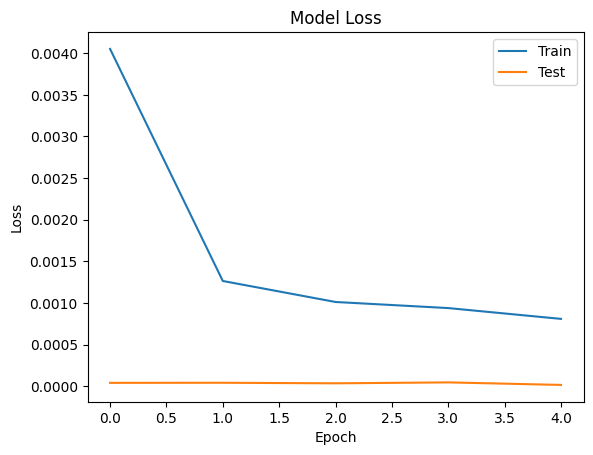

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Test Scaled RMSE var1: 0.005
Test Scaled RMSE var2: 0.003
Test RMSE var1: 0.119
Test RMSE var2: 0.023


In [14]:
temp = LSTMDataPreparer(df, n_in=24, n_out=1,test_days=7)
temp.train_model()
temp.evaluate()
temp.model.save("lstm.h5")

In [8]:
from joblib import dump, load
dump(temp.scaler, 'minmax_scaler.joblib')

['minmax_scaler.joblib']